# Insert Project Title

## Introduction 
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question


The purpose of this Data Science Project is to perform an analysis to answer a predictive question using the Minecraft server, PlaiCraft, dataset. Specifically, we'd like to better understand the details regarding player engagement and demographics. This dataset was collected by a research group in Computer Science at UBC to explore how people play video games. In this Project Planning Report, a brief data description, proposed question, exploratory data analysis and visualization will be presented along with a structured approach and plan.

### Data Description

 The data being used on this project was collected by having individuals play on UBC's research group's Mincraft served called PlaiCraft. The data collected consisted of information such as player experience, their session durations, and furthmore. The files we are presented with consists of players.csv and sessions.csv.

#### Players Dataset
The players.csv file contains information collected from the Minecraft server with 197 observations and 7 columns. Each observation is representative of a player. 

Further information about the dataset can be seen in the following table:

|  Variable Name | Variable Data Type |                          Description                                | 
|:--------------:|:------------------:|:-------------------------------------------------------------------:|
|  experience    |  Character         |   Describes if a player is a Pro, Veteran, Beginner or Amateur	    |  
|  subscribe     |  Logical           |   Denotes if a player has subscribed to PlaiCraft's email updates   |   
|  hashedEmail   |  Character         |   The hashed email for each player                                  |  
| played_hours   |  Double            |   The total number of hours a player has played                     |
|  name          |  Character         |   The player's alias                                                |  
|  gender        | Character          |   The player's gender, either male or female                        |  
|  age           |  Double            |   The player's age                                                  | 


#### Sessions Dataset
The sessions.csv file contains information collected from the Minecraft server with 1535 observations and 5 columns. Each observation is representative of a player's playing session, noting the start and end times of that session.
Further information about the dataset can be seen in the following table:

|  Variable Name       | Variable Data Type |                          Description                                | 
|:--------------------:|:------------------:|:-------------------------------------------------------------------:| 
|  hashedEmail         |  Character         |   The hashed email for each player                                  |  
|  start_time          |  Character         |   The player's actual start time of the session                     |
|  end_time            |  Character         |   The player's actual end time of the session                       |  
|  original_start_time |  Double            |   The player's scheduled start times in UNIX timestamp format       |  
|  original_end_time   |  Double            |   The player's scheduled end times in UNIX timestamp format         | 

## Methods & Results 
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
loads data 
wrangles and cleans the data to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all figures should have a figure number and a legend


## Discussion
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

# Analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library (lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")|>
    select(-individualId, -organizationName)

sessions_data <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_analysis_data <- sessions_data |> 
    mutate (start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate (end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))|>
    mutate (converted_end_sec = as.numeric(as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (converted_start_sec = as.numeric(as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (duration = (converted_end_sec - converted_start_sec )/(60)) |>
    select (-original_start_time, -original_end_time)|>
    group_by (hashedEmail)|>
    summarize(total_duration_min = sum(duration))

In [4]:
combined_data <- left_join(players_data, players_analysis_data, by="hashedEmail") |>
    mutate(total_duration_min = replace_na(total_duration_min, 0)) |>
    mutate(id_number = row_number())|>
    select (id_number, everything(), - hashedEmail, -name)


In [5]:
head(combined_data) 

id_number,experience,subscribe,played_hours,gender,age,total_duration_min
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019
2,Veteran,TRUE,3.8,Male,17,255
3,Veteran,FALSE,0.0,Male,17,5
4,Amateur,TRUE,0.7,Female,21,50
5,Regular,TRUE,0.1,Male,21,9
6,Amateur,TRUE,0.0,Female,17,0


In [6]:
raw_data <- combined_data|>
    mutate(numerical_experience = case_when(
    experience == "Amateur" ~ 1,
    experience == "Beginner" ~ 2,
    experience == "Regular" ~ 3,
    experience == "Pro" ~ 4,
    experience == "Veteran" ~ 5))

head(combined_data)

id_number,experience,subscribe,played_hours,gender,age,total_duration_min
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019
2,Veteran,TRUE,3.8,Male,17,255
3,Veteran,FALSE,0.0,Male,17,5
4,Amateur,TRUE,0.7,Female,21,50
5,Regular,TRUE,0.1,Male,21,9
6,Amateur,TRUE,0.0,Female,17,0


## Filtering Data and Splitting

Played Hours

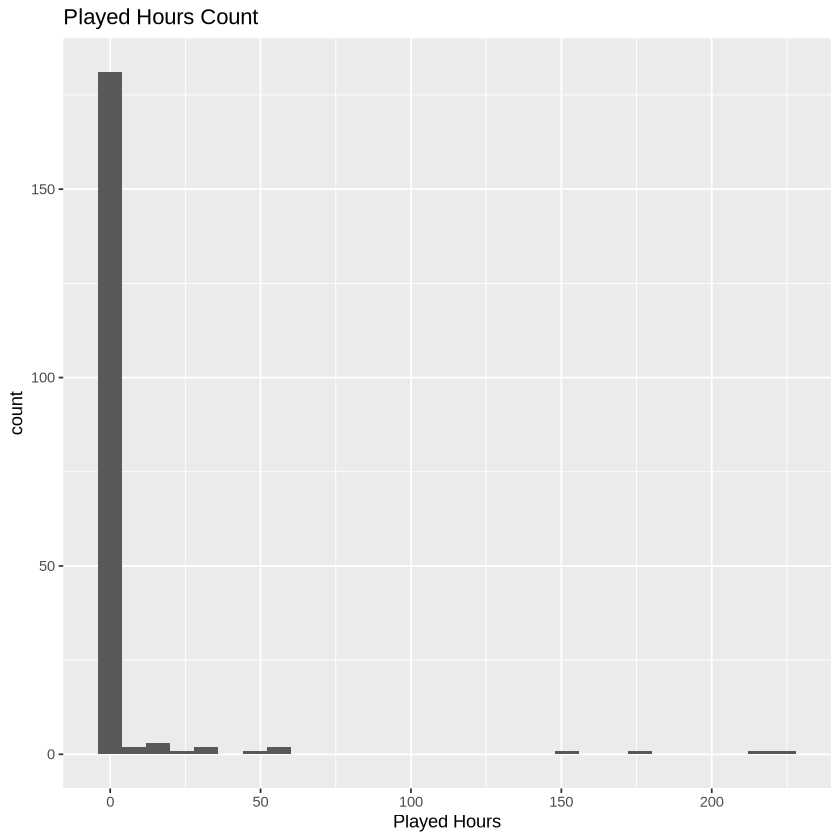

In [7]:
Played_hours_hist<- raw_data |>
                    ggplot(aes(x = played_hours))+
                    geom_histogram(binwidth = 8) +
                    labs(x = "Played Hours", title= "Played Hours Count")
Played_hours_hist

In [8]:
set.seed(2000)
combined_data <- raw_data |>
    filter(age <=55) |> 
    filter(total_duration_min <=200) 

data_split <- initial_split(combined_data, prop = 0.75, strata = total_duration_min) 

data_training <- training(data_split)
data_testing <- testing(data_split)

## Numerical Experience = No good relationship

In [ ]:
raw_training_plot <- data_training |>
    ggplot(aes (x = numerical_experience, y= total_duration_min)) +
    geom_point()+
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Experience Vs Total Play Time")

raw_training_plot

In [ ]:
raw_training_bar <- data_training |>
    ggplot(aes(x = numerical_experience, y = total_duration_min)) +
    geom_bar(stat = "identity", fill = "blue", color = "blue") +
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
         title = "Experience Vs Total Play Time")

raw_training_bar

## Using Age 

In [ ]:
filtered_data <- data_training |>
    filter(total_duration_min <= 200) |>
    filter(age <= 50)
    

raw_training_plot <- filtered_data |>
    ggplot(aes (x = age, y= total_duration_min)) +
    geom_point()+
    labs(x = "Age of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Age Vs Total Play Time")

raw_training_plot

## Regression Model

In [ ]:
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode ("regression")

lm_recipe <- recipe(total_duration_min ~ age, data = data_training)

lm_fit <- workflow() |>
      add_recipe(lm_recipe) |>
      add_model(lm_spec) |>
      fit(data = data_training)
lm_fit

In [ ]:
data_preds <- lm_fit |>
  predict(data_training) |>
  bind_cols(data_training)

lm_predictions <- data_preds |>
    ggplot(aes(x = age, y = total_duration_min)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = age, y = .pred), 
            color = "blue") +
        xlab("Age") +
        ylab("Play Time Duration ") +
        ggtitle("Predicted vs Actual Play Time (Limited to 200 Minutes) of Training Set")+
        theme(text = element_text(size = 12))

lm_predictions

In [ ]:
lm_test_results <- lm_fit |>
        predict(data_testing) |>
        bind_cols(data_testing) |>
        metrics(truth = total_duration_min, estimate = .pred)

lm_rmspe <- lm_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

In [ ]:
test_preds <- lm_fit |> 
    predict(data_testing) |>
    bind_cols(data_testing) 
    
lm_predictions_test <- test_preds |> 
    ggplot(aes (x=age, y = total_duration_min)) +
    geom_point(alpha = 0.4) +
    geom_line(
        data = test_preds, 
        mapping = aes (x = age, y = .pred),
        colour = "blue",
        linewidth = 1) +
    labs(x = "Player Age",
         y = "Play Time (mins)",
        title= "Predicted vs Actual Play Time (Limited to 200 Minutes) of Testing Set")

lm_predictions_test

In [ ]:
age_prediction_grid <- tibble(
    age = c(
        combined_data |> select(age) |> min(),
        combined_data |> select(age) |> max()
    )
)

data_preds <- lm_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

lm_plot_final <- ggplot(combined_data, aes(x = age, y = total_duration_min)) +
  geom_point(alpha = 0.4) +
  geom_line(data = data_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Play Time Duration (mins)") +
  ggtitle("Predicted vs Actual Play Time (Limited to 200 Minutes)")+
  theme(text = element_text(size = 12))

lm_plot_final

In [ ]:
coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
coeffs 

Extracting the coefficients from the model, we can find that the equation of the regression line is:

$Play Time = -0.060(Player Age) + 25.63$